In [1]:
import sys
import numpy as np
import xarray as xr
import itertools as it
import multiprocessing as mp
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.rcsetup as rcsetup
import tensorflow as tf
import sklearn
from keras.layers import *
from keras.regularizers import l1,l2
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.losses import mse
from keras import backend as K
from livelossplot.keras import PlotLossesCallback

CPU_COUNT = mp.cpu_count()
print('{} CPUs'.format(CPU_COUNT))
print('numpy version: {}'.format(np.__version__))
print('xarray version: {}'.format(xr.__version__))
print('matplotlib version: {}'.format(matplotlib.__version__))
print('sklearn version: {}'.format(sklearn.__version__))
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

Using TensorFlow backend.


8 CPUs
numpy version: 1.15.4
xarray version: 0.11.3
matplotlib version: 3.0.2
sklearn version: 0.20.1


In [2]:
X_ccsm4 = xr.open_dataset('data/rcp26/CCSM4/rcp26_CCSM4_grid.nc')
X_ccsm4_arr = X_ccsm4.to_array().values
X_cesm = xr.open_dataset('data/rcp26/CESM1-CAM5/rcp26_CESM1-CAM5_grid.nc')
X_cesm_arr = X_cesm.to_array().values
X_canesm = xr.open_dataset('data/rcp26/CanESM2/rcp26_CanESM2_grid.nc')
X_canesm_arr = X_canesm.to_array().values
X_cnrm = xr.open_dataset('data/rcp26/CNRM-CM5/rcp26_CNRM-CM5_grid.nc')
X_cnrm_arr = X_cnrm.to_array().values
X_miroc = xr.open_dataset('data/rcp26/MIROC5/rcp26_MIROC5_grid.nc')
X_miroc_arr = X_miroc.to_array().values
X_mpi = xr.open_dataset('data/rcp26/MPI-ESM-LR/rcp26_MPI-ESM-LR_grid.nc')
X_mpi_arr = X_mpi.to_array().values

In [3]:
X_all_arr = np.array([X_ccsm4_arr, X_cesm_arr, X_canesm_arr, X_cnrm_arr, X_miroc_arr])
X_all_arr = np.transpose(X_all_arr, axes=[0,2,3,4,1])
print(X_all_arr.shape)

(5, 2880, 72, 144, 1)


In [4]:
N_models, N_time, N_lat, N_lon, N_chan = X_all_arr.shape
BATCH_SIZE = N_models*144

In [5]:
X_all = np.hstack(X_all_arr).reshape((N_models*N_time, N_lat, N_lon, N_chan))
print(X_all.shape)

(14400, 72, 144, 1)


In [6]:
X_train = X_all
X_valid = np.transpose(X_mpi_arr, axes=[1,2,3,0])
print(X_valid.shape)

(2880, 72, 144, 1)


In [7]:
n_count = np.count_nonzero(~np.isnan(X_all))
print('Found {} NaN values in data'.format(np.product(X_all.shape) - n_count))

Found 0 NaN values in data


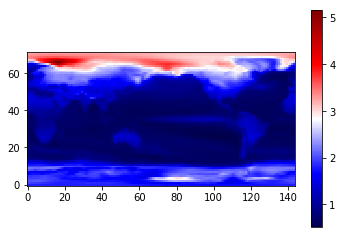

In [8]:
X_std = np.std(X_train, axis=0)
plt.imshow(X_std.squeeze(), origin='lower', cmap='seismic')
plt.colorbar()
plt.show()

In [9]:
def plot_var_spatial(X, model, target_shape=(1, N_lat, N_lon, N_chan), name="model", t=0, c=0):
    X_t = X[c,t,:,:]
    X_pred = model.predict(X_t.reshape(target_shape)).reshape((N_lat, N_lon))
    plt.figure(figsize=(12,10))
    plt.subplot(1,2,1)
    plt.imshow(X_t, origin='lower')
    plt.title("{}, t={}".format(name, t))
    plt.subplot(1,2,2)
    plt.imshow(X_pred, origin='lower')
    plt.title("{}, t={}, decoded".format(name, t))
    plt.show()
    
def plot_err_spatial(X, model, target_shape=(1, N_lat, N_lon, N_chan), name="", t=0):
    plt.figure(figsize=(7,6))
    X_t = np.transpose(X, axes=[1,2,3,0])[t,:,:,:]
    X_pred = model.predict(X_t.reshape(target_shape)).reshape((N_lat, N_lon))
    print(X_pred.shape)
    X_err = np.abs(X_t.reshape((N_lat, N_lon)) - X_pred)
    plt.imshow(X_err.reshape((N_lat, N_lon)), origin='lower')
    plt.colorbar()
    plt.show()
    
def plot_var_time(X, model, target_shape=(N_time, N_lat, N_lon, N_chan), name="", c=0):
    X_orig = np.transpose(X, axes=[1,2,3,0])
    X_pred = model.predict_on_batch(X_orig.reshape(target_shape))
    plt.plot(range(X_orig.shape[0]), np.mean(X_orig, axis=(1,2))[:,c], c='blue')
    plt.plot(range(X_orig.shape[0]), np.mean(X_pred, axis=(1,2))[:,c], ':', c='red')
    plt.show()
    
def show_activations(X, model, layer, output_shape, t=0, name=""):
    X_t = np.transpose(X, axes=[1,2,3,0])[t,:,:,:]
    inputs = [K.learning_phase()] + model.inputs
    layer_fn = K.function(inputs, [layer.output])
    layer_out = layer_fn([0, X_t.reshape((1, *X_t.shape))])[0]
    z_0 = z[t].reshape(output_shape)
    plt.imshow(z_0, origin='lower')
    plt.colorbar()
    plt.show()

### Dense Autoencoder

In [56]:
def build_dense_autoencoder(latent_dims: int, regularizer=l1(1.0e-5)):
    input_0 = Input(shape=(N_lat, N_lon, N_chan))
    z = Dense(latent_dims, activation='relu', kernel_regularizer=regularizer)(Flatten()(input_0))
    def build_decoder(input_z):
        dense_out = Dense(np.product(X_train.shape[1:]), activation='linear')(input_z)
        output = Reshape(X_train.shape[1:])(dense_out)
        return output
    output_0 = build_decoder(z)
    # build standalone encoder/decoder
    encoder = Model(inputs=input_0, outputs=z)
    decoder_input = Input(shape=(latent_dims,))
    decoder_output = build_decoder(decoder_input)
    decoder = Model(inputs=decoder_input, outputs=decoder_output)
    dae = Model(inputs=input_0, outputs=output_0)
    dae.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return dae, encoder, decoder

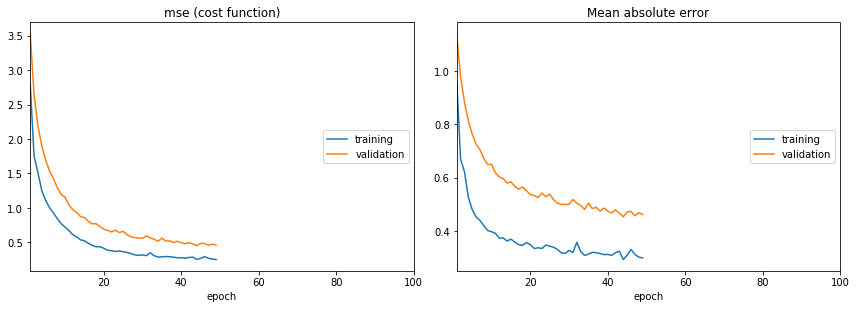

mse (cost function):
training   (min:    0.249, max:    2.800, cur:    0.250)
validation (min:    0.451, max:    3.529, cur:    0.461)

Mean absolute error:
training   (min:    0.293, max:    0.960, cur:    0.299)
validation (min:    0.453, max:    1.140, cur:    0.462)


In [35]:
dae, dae_encoder, dae_decoder = build_dense_autoencoder(latent_dims=18*36)
callbacks = [EarlyStopping(min_delta=1.0E-3, patience=5), PlotLossesCallback()]
dae.fit(X_train, X_train, validation_data=(X_valid, X_valid), \
        batch_size=BATCH_SIZE, epochs=100, shuffle=True, callbacks=callbacks)

(1, 2880, 72, 144)


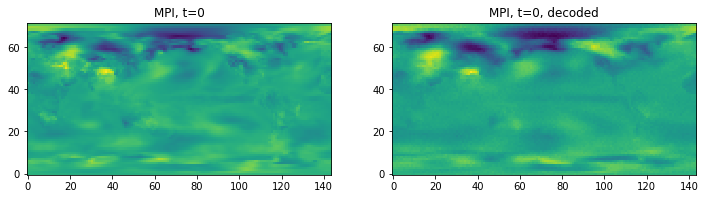

(72, 144)


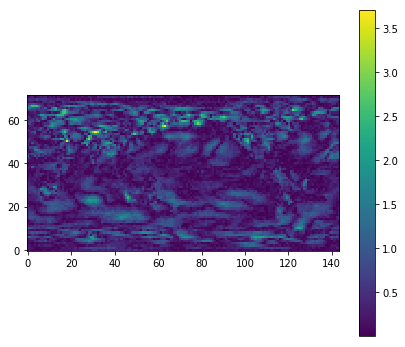

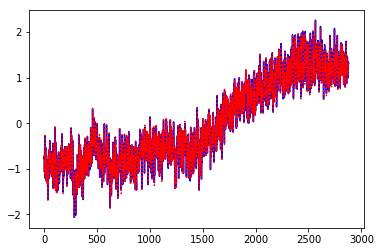

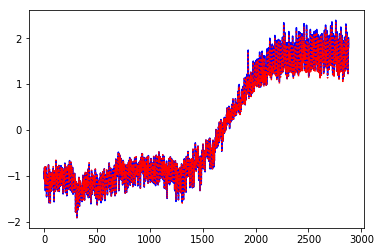

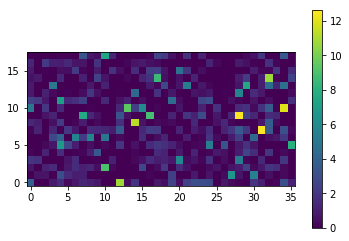

In [89]:
print(X_mpi_arr.shape)
plot_var_spatial(X_mpi_arr, dae, name="MPI")
plot_err_spatial(X_mpi_arr, dae, name="MPI")
plot_var_time(X_mpi_arr, dae)
plot_var_time(X_canesm_arr, dae)
show_activations(X_mpi_arr, dae, dae.layers[2], (18,36))

### Convolutional model

In [93]:
def build_conv_autoencoder(n_filters: int, n_downsamples: int = 2, regularizer = l2(1.0E-5)):
    assert n_downsamples > 0
    assert n_downsamples < N_lat / 2
    relu = ReLU()
    def conv_encoder(prev_layer):
        conv_0 = Conv2D(n_filters, (3,3), kernel_regularizer=regularizer, padding='same')
        conv_1 = Conv2D(n_filters, (3,3), kernel_regularizer=regularizer, padding='same')
        conv_dn = Conv2D(n_filters, (3,3), strides=(2,2), kernel_regularizer=regularizer, padding='same')
        return relu (conv_dn (relu (conv_1 (relu (conv_0 (prev_layer))))))
    def conv_decoder(prev_layer):
        tconv_0 = Conv2DTranspose(n_filters, (3,3), kernel_regularizer=regularizer, padding='same')
        tconv_1 = Conv2DTranspose(n_filters, (3,3), kernel_regularizer=regularizer, padding='same')
        tconv_up = Conv2DTranspose(n_filters, (3,3), strides=(2,2), kernel_regularizer=regularizer, padding='same')
        return relu (tconv_up (relu (tconv_1 (relu (tconv_0 (prev_layer))))))
    def build_decoder(input_z):
        z_reshape = Reshape((latent_x,latent_y,1))
        h_decoder = z_reshape(input_z)
        for i in range(n_downsamples):
            h_decoder = conv_decoder(h_decoder)
        conv_out = Conv2D(1, (3,3), padding='same')
        return conv_out(h_decoder)
    
    latent_x, latent_y = int(N_lat / 2**n_downsamples), int(N_lon / 2**n_downsamples)
    latent_dims = latent_x*latent_y
    input_0 = Input(shape=(N_lat, N_lon, N_chan))
    h_encoder = input_0
    for i in range(n_downsamples):
        h_encoder = conv_encoder(h_encoder)
    z = Dense(latent_dims, kernel_regularizer=regularizer)(Flatten()(h_encoder))
    output_0 = build_decoder(relu(z))
    # build encoder/decoder models
    encoder = Model(inputs=input_0, outputs=z)
    decoder_input = Input(shape=(latent_dims,))
    decoder_output = build_decoder(decoder_input)
    decoder = Model(inputs=decoder_input, outputs=decoder_output)
    # build end-to-end model
    cae = Model(inputs=input_0, outputs=output_0)
    cae.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return cae, encoder, decoder, latent_dims

In [94]:
conv_model, conv_encoder, conv_decoder, conv_latent_dims = build_conv_autoencoder(n_filters=8)

callbacks = [EarlyStopping(min_delta=1.0E-3, patience=5), PlotLossesCallback()]
conv_model.fit(X_train, X_train, batch_size=BATCH_SIZE, epochs=100, shuffle=True, validation_data=(X_valid, X_valid), callbacks=callbacks)

Train on 14400 samples, validate on 2880 samples
Epoch 1/100


Exception ignored in: <function _TFShouldUseHelper.__del__ at 0x7f3cf8d17e18>
Traceback (most recent call last):
  File "/home/brian/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/tf_should_use.py", line 55, in __del__
    if ops.executing_eagerly_outside_functions():
  File "/home/brian/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 5386, in executing_eagerly_outside_functions
    return context.executing_eagerly()
  File "/home/brian/anaconda3/lib/python3.7/contextlib.py", line 119, in __exit__
    next(self.gen)
  File "/home/brian/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 5371, in init_scope
    yield
  File "/home/brian/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 6099, in __exit__
    self._name_scope.__exit__(type_arg, value_arg, traceback_arg)
  File "/home/brian/anaconda3/lib/python3.7/contextlib.py", line 119, in __exit__
    next(self.gen)
  File "/home/bri

 2880/14400 [=====>........................] - ETA: 55s - loss: 2.7228 - mean_absolute_error: 1.0952 

KeyboardInterrupt: 

In [21]:
plot_var_spatial(X_ccsm4_arr, conv_model)

NameError: name 'conv_model' is not defined

### LSTM model

In [97]:
def build_lstm_autoencoder(latent_dims: int, hidden_dims: int, timesteps=N_time, regularizer=l2(1.0E-5), stateful=False):
    relu = ReLU()
    flat_input_dims = N_lat*N_lon*N_chan
    def build_decoder(input_z):
        repeat = RepeatVector(timesteps)
        lstm = LSTM(latent_dims, activation='relu', kernel_regularizer=regularizer, \
                    recurrent_regularizer=regularizer, stateful=stateful, return_sequences=True)
        dense_h = TimeDistributed(Dense(hidden_dims, activation='relu'))
        dense_out = TimeDistributed(Dense(flat_input_dims, activation='linear'))
        reshape_output = Reshape((timesteps, N_lat, N_lon, N_chan))
        return reshape_output (dense_out (dense_h (lstm (repeat (input_z)))))
    input_0 = Input(shape=(timesteps, N_lat, N_lon, N_chan))
    # encoder
    reshape_input = Reshape((timesteps, flat_input_dims))
    dense_h = TimeDistributed(Dense(hidden_dims, activation='relu'))
    lstm = LSTM(latent_dims, activation='relu', kernel_regularizer=regularizer, \
                recurrent_regularizer=regularizer, stateful=stateful, return_sequences=False)
    z = lstm (dense_h (reshape_input (input_0)))
    output_0 = build_decoder(z)
    # create encoder/decoder models
    encoder = Model(inputs=input_0, outputs=z)
    decoder_input = Input(shape=(latent_dims,))
    decoder_output = build_decoder(decoder_input)
    decoder = Model(inputs=decoder_input, outputs=decoder_output)
    # end to end model
    model = Model(inputs=input_0, outputs=output_0)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model, encoder, decoder

In [ ]:
lstm_model, lstm_encoder, lstm_decoder = build_lstm_autoencoder(latent_dims=256, hidden_dims=1024)
X_train_lstm = X_all_arr
X_valid_lstm = np.array([np.transpose(X_mpi_arr, axes=[1,2,3,0])])

callbacks = [EarlyStopping(min_delta=1.0E-3, patience=5), PlotLossesCallback()]
lstm_model.fit(X_train_lstm, X_train_lstm, batch_size=BATCH_SIZE, epochs=100, shuffle=True, validation_data=(X_valid_lstm, X_valid_lstm), callbacks=callbacks)

Train on 5 samples, validate on 1 samples
Epoch 1/100


### Dense Variational Autoencoder

In [8]:
inter_dims = 1024
latent_dims = 256
epsilon_std = 1

input_0 = Input(batch_shape=(BATCH_SIZE, N_lat, N_lon, N_chan))
dense_0 = Dense(inter_dims, activation='relu', kernel_initializer='zeros', activity_regularizer=l2(1.0E-5))(Flatten()(input_0))
z_mean = Dense(latent_dims, kernel_initializer='ones', activity_regularizer=l2(1.0E-5))(dense_0)
z_log_sigma = Dense(latent_dims, kernel_initializer='ones', activity_regularizer=l2(1.0E-5))(dense_0)
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=K.shape(z_mean), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_sigma) * epsilon
z = Lambda(sampling)([z_mean, z_log_sigma])

dense_1 = Dense(inter_dims)(z)
dense_2 = Dense(N_lat*N_lon*N_chan, activation='relu')(dense_1)
reshaped = Reshape((N_lat, N_lon, N_chan))(dense_2)
vae_model = Model(inputs=input_0, outputs=reshaped)
def vae_loss(x, x_):
    mse_loss = mse(K.flatten(x), K.flatten(x_))
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    print(mse_loss)
    print(kl_loss)
    return mse_loss + kl_loss

vae_model.compile(optimizer='adam', loss=vae_loss, metrics=['mae'])
vae_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (864, 72, 144, 1)    0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (864, 10368)         0           input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (864, 5184)          53752896    flatten_1[0][0]                  
__________________________________________________________________________________________________
dense_2 (Dense)                 (864, 256)           1327360     dense_1[0][0]                    
_____________________________________

### Convolutional Variational Autoencoder

In [33]:
def kl_loss(z_mean, z_log_sigma):
    return - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1);

def build_conv_vae(n_filters: int, n_downsamples: int = 2, beta=0.5, regularizer = l2(1.0E-5)):
    """
    n_filters     : number of convolutional filters to use in encoder and decoder
    n_downsamples : number of convolutional downsampling steps to apply
    beta          : weight hyper-parameter in [0,1] for balancing between MSE and KL loss; 0.5 is equal weight
    regularizer   : Keras regularizer for convolution and dense layers
    """
    assert n_downsamples > 0
    assert n_downsamples < N_lat / 2
    latent_x, latent_y = int(N_lat / 2**n_downsamples), int(N_lon / 2**n_downsamples)
    latent_dims = latent_x*latent_y
    print('building model with {}x{} = {} latent dims'.format(latent_x, latent_y, latent_dims))
    relu = ReLU()
    def conv_encoder(prev_layer):
        conv_0 = Conv2D(n_filters, (3,3), kernel_regularizer=regularizer, padding='same')
        conv_1 = Conv2D(n_filters, (3,3), kernel_regularizer=regularizer, padding='same')
        conv_dn = Conv2D(n_filters, (3,3), strides=(2,2), kernel_regularizer=regularizer, padding='same')
        return PReLU() (conv_dn (PReLU() (conv_1 (PReLU() (conv_0 (prev_layer))))))
    def conv_decoder(prev_layer):
        tconv_0 = Conv2DTranspose(n_filters, (3,3), kernel_regularizer=regularizer, padding='same')
        tconv_1 = Conv2DTranspose(n_filters, (3,3), kernel_regularizer=regularizer, padding='same')
        tconv_up = Conv2DTranspose(n_filters, (3,3), strides=(2,2), kernel_regularizer=regularizer, padding='same')
        return relu (tconv_up (relu (tconv_1 (relu (tconv_0 (prev_layer))))))
    def build_encoder(X_input):
        h_encoder = X_input
        for i in range(n_downsamples):
            h_encoder = conv_encoder(h_encoder)
        z_mean = Dense(latent_dims, kernel_regularizer=l2(1.0E-5))(Flatten()(h_encoder))
        z_log_sigma = Dense(latent_dims, kernel_regularizer=l2(1.0E-5))(Flatten()(h_encoder))
        return z_mean, z_log_sigma
    def build_decoder(z_mean, z_log_sigma, sampler_input):
        def compute_z(args):
            z_mean, z_log_sigma = args
            return z_mean + K.exp(z_log_sigma) * sampler_input
        z = Lambda(compute_z, output_shape=(latent_dims,))
        z_reshape = Reshape((latent_x,latent_y,1))
        h_decoder = z_reshape (z ([z_mean, z_log_sigma]))
        for i in range(n_downsamples):
            h_decoder = conv_decoder(h_decoder)
        conv_out = Conv2D(1, (3,3), padding='same')
        return conv_out(h_decoder)
    
    # encoder input
    input_0 = Input(shape=(N_lat, N_lon, N_chan), name='X')
    # sampler input
    input_1 = Input(shape=(latent_dims,), name='samples')
    
    z_mean, z_log_sigma = build_encoder(input_0)
    output_0 = build_decoder(z_mean, z_log_sigma, input_1)
    # build encoder/decoder models
    encoder = Model(inputs=input_0, outputs=[z_mean, z_log_sigma])
    decoder_input_mean = Input(shape=(latent_dims,))
    decoder_input_log_sigma = Input(shape=(latent_dims,))
    decoder_input_samples = Input(shape=(latent_dims,))
    decoder_output = build_decoder(decoder_input_mean, decoder_input_log_sigma, decoder_input_samples)
    decoder = Model(inputs=[decoder_input_mean, decoder_input_log_sigma, decoder_input_samples], outputs=decoder_output)
    # build end-to-end model
    def vae_loss(x, x_):
        mse_loss = mse(K.flatten(x), K.flatten(x_))
        return (1-beta)*mse_loss + beta*kl_loss(z_mean, z_log_sigma)
    vae = Model(inputs=[input_0, input_1], outputs=output_0)
    vae.compile(optimizer='adam', loss=vae_loss, metrics=['mse', 'mae'])
    return vae, encoder, decoder, latent_dims

In [35]:
vae_model, vae_encoder, vae_decoder, vae_latent_dims = build_conv_vae(n_filters=8)
# random sampler input for VAE
X_train_seed = np.random.randn(X_train.shape[0], vae_latent_dims)
X_valid_seed = np.random.randn(X_valid.shape[0], vae_latent_dims)

callbacks = [EarlyStopping(min_delta=1.0E-5, patience=5, restore_best_weights=True), PlotLossesCallback()]
vae_model.fit([X_train, X_train_seed], X_train, batch_size=BATCH_SIZE, epochs=100, shuffle=True, \
              validation_data=([X_valid, X_valid_seed], X_valid), callbacks=callbacks)

building model with 18x36 = 648 latent dims
Instructions for updating:
Use tf.cast instead.
Train on 14400 samples, validate on 2880 samples
Epoch 1/100
 5040/14400 [=========>....................] - ETA: 1:03 - loss: 1.4007 - mean_squared_error: 2.7549 - mean_absolute_error: 1.1025

KeyboardInterrupt: 

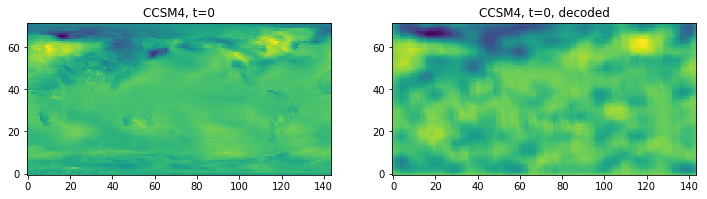

(72, 144)


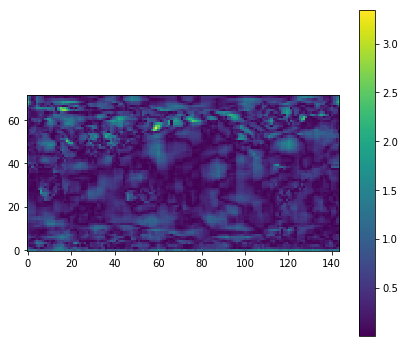

(2880, 72, 144, 1)


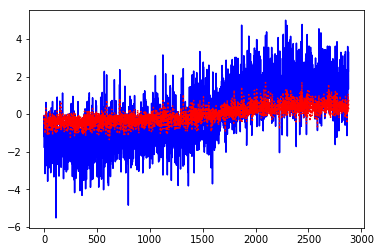

In [20]:
plot_var_spatial(X_ccsm4_arr, vae_model, name="CCSM4")
plot_err_spatial(X_ccsm4_arr, vae_model, name="CCSM4")
plot_var_time(X_ccsm4_arr, vae_model)